# Football Performance Analysis

## Data Overview 

The analysis is performed on two sets of data.
***
Event Data:

Event data records specific in-game events such as passes, tackles, and shots.
Information recorded includes when these events occurred in the match, where they occurred on the field (start and end locations for passes, shot locations), and the players involved.
Typically, each match results in a few thousand recorded events.
Event data focuses solely on on-ball activities, providing limited information about the positions and actions of players when they are not directly interacting with the ball.
***
Tracking Data:

Tracking data provides a more comprehensive view of the match by continuously measuring the location of all 22 players on the field and the ball.
Data is sampled at a rate of 25 Hertz, resulting in approximately 25 observations per second for each player and the ball.
This data offers a complete picture of player positions and movements throughout the match.
Tracking data generates several million observations per match, which is about a thousand times more data points compared to event data.

***

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv as csv
import matplotlib.animation as animation
import scipy.signal as signal

In [2]:
#reading event data
events = pd.read_csv("/Users/gkrish/Documents/Football Performance Analysis/\
sample-data-master/data/Sample_Game_2/Sample_Game_2_RawEventsData.csv")

In [3]:
#verifying event data
events.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.50,0.50,0.40,0.51
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,0.43,0.50,0.44,0.22
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,0.47,0.19,0.31,0.28
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,0.29,0.32,0.26,0.58


In [4]:
#reading tracking data

#The format of the tracking data file is not in a way to directly read it. Hence we need to perform the following
#operations to get the data in a form suitable for analysis


def tracking_data(teamname):
    teamfile = '/Sample_Game_2/Sample_Game_2_RawTrackingData_%s_Team.csv' % (teamname)
    
    #getting the team name
    csvfile =  open('/Users/gkrish/Documents/Football Performance Analysis/\
sample-data-master/data/{}'.format(teamfile), 'r') # create a csv file reader
    reader = csv.reader(csvfile) 
    teamnamefull = next(reader)[3].lower()
    print("Reading team: %s" % teamnamefull)
    
    #creating column names
    jerseys = [x for x in next(reader) if x != ''] # extracting player jersey numbers from second row
    columns = next(reader)
    for i, j in enumerate(jerseys): # create x & y position column headers for each player
        columns[i*2+3] = "{}_{}_x".format(teamname, j)
        columns[i*2+4] = "{}_{}_y".format(teamname, j)
    columns[-2] = "ball_x" # column headers for the x & y positions of the ball
    columns[-1] = "ball_y"
    
    #reading tracking data
    tracking = pd.read_csv('/Users/gkrish/Documents/Football Performance Analysis/\
sample-data-master/data/{}'.format(teamfile), names=columns, index_col='Frame', skiprows=3)
    return tracking

In [5]:
tracking_home = tracking_data('Home')
tracking_away = tracking_data('Away')

Reading team: home
Reading team: away


In [6]:
#verifying tracking data(home team)
tracking_home.head()

,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,...,Home_10_x,Home_10_y,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y,ball_x,ball_y
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,...,0.50194,0.61123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,...,0.50194,0.61123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,...,0.50194,0.61123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,...,0.50194,0.61123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,...,0.50194,0.61123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#verifying tracking data(away team)
tracking_away.head()

,Period,Time [s],Away_25_x,Away_25_y,Away_15_x,Away_15_y,Away_16_x,Away_16_y,Away_17_x,Away_17_y,...,Away_22_x,Away_22_y,Away_23_x,Away_23_y,Away_24_x,Away_24_y,Away_26_x,Away_26_y,ball_x,ball_y
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,0.38954,...,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,NaN,NaN,NaN,NaN
2,1,0.08,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,0.38954,...,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,NaN,NaN,NaN,NaN
3,1,0.12,0.01218,0.51763,0.32891,0.81846,0.30734,0.55182,0.32235,0.38954,...,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,NaN,NaN,NaN,NaN
4,1,0.16,0.01218,0.51763,0.32836,0.81847,0.30734,0.55182,0.32235,0.38954,...,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,NaN,NaN,NaN,NaN
5,1,0.20,0.01218,0.51763,0.32783,0.81847,0.30734,0.55182,0.32235,0.38954,...,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,NaN,NaN,NaN,NaN


## Exploring the events data

In [8]:
#counting the number of each event type in the data
print(events['Type'].value_counts())

Type
PASS              964
CHALLENGE         311
RECOVERY          248
BALL LOST         233
SET PIECE          80
BALL OUT           49
SHOT               24
FAULT RECEIVED     20
CARD                6
Name: count, dtype: int64


### Changing the coordinate system

The events data uses a coordinate system where the length of the football field is represented as one unit, the width of the field is one unit, and the origin is at the top right-hand corner of the field. However, for more practical and recognizable measurements, the dataset is being switched to a new coordinate system with the following characteristics:

Field Dimensions: The length of the football field is now represented as 106 meters, and the width of the field is 68 meters. These measurements are in standard units of meters, making it easier to work with real-world distances.

Origin: The origin of this new coordinate system is at the center of the football field.

This change in the coordinate system allows for more meaningful calculations, such as determining player speeds in meters per second and measuring the distance traveled by players during the game in meters. It aligns the dataset with commonly used measurement standards in football analysis.

In [9]:
#changing the coordinate system
def to_metric_coordinates(data,field_dimen=(106.,68.) ):
    x_columns = [c for c in data.columns if c[-1].lower()=='x']
    y_columns = [c for c in data.columns if c[-1].lower()=='y']
    data[x_columns] = ( data[x_columns]-0.5 ) * field_dimen[0]
    data[y_columns] = -1 * ( data[y_columns]-0.5 ) * field_dimen[1]
    return data

events = to_metric_coordinates(events)

In [10]:
#verifying change in coordinate system
events.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.00,-0.00,-10.60,-0.68
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,-7.42,-0.00,-6.36,19.04
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,-3.18,21.08,-20.14,14.96
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,-22.26,12.24,-25.44,-5.44


In [11]:
#getting events by team
home_events = events[events['Team']=='Home']
away_events = events[events['Team']=='Away']

In [12]:
#frequency of each event type by team
print(home_events['Type'].value_counts())
print(away_events['Type'].value_counts())

Type
PASS              543
CHALLENGE         160
RECOVERY          135
BALL LOST         120
SET PIECE          34
BALL OUT           27
SHOT               13
FAULT RECEIVED      9
CARD                3
Name: count, dtype: int64
Type
PASS              421
CHALLENGE         151
BALL LOST         113
RECOVERY          113
SET PIECE          46
BALL OUT           22
SHOT               11
FAULT RECEIVED     11
CARD                3
Name: count, dtype: int64


In [13]:
#plotting a football pitch
#this code was taken from a public github repo
def plot_pitch( field_dimen = (106.0,68.0), field_color ='green', linewidth=2, markersize=20):
    fig,ax = plt.subplots(figsize=(12,8)) # create a figure 
    # decide what color we want the field to be. Default is green, but can also choose white
    if field_color=='green':
        ax.set_facecolor('mediumseagreen')
        lc = 'whitesmoke' # line color
        pc = 'w' # 'spot' colors
    elif field_color=='white':
        lc = 'k'
        pc = 'k'
    # ALL DIMENSIONS IN m
    border_dimen = (3,3) # include a border arround of the field of width 3m
    meters_per_yard = 0.9144 # unit conversion from yards to meters
    half_pitch_length = field_dimen[0]/2. # length of half pitch
    half_pitch_width = field_dimen[1]/2. # width of half pitch
    signs = [-1,1] 
    # Soccer field dimensions typically defined in yards, so we need to convert to meters
    goal_line_width = 8*meters_per_yard
    box_width = 20*meters_per_yard
    box_length = 6*meters_per_yard
    area_width = 44*meters_per_yard
    area_length = 18*meters_per_yard
    penalty_spot = 12*meters_per_yard
    corner_radius = 1*meters_per_yard
    D_length = 8*meters_per_yard
    D_radius = 10*meters_per_yard
    D_pos = 12*meters_per_yard
    centre_circle_radius = 10*meters_per_yard
    # plot half way line # center circle
    ax.plot([0,0],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
    ax.scatter(0.0,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
    y = np.linspace(-1,1,50)*centre_circle_radius
    x = np.sqrt(centre_circle_radius**2-y**2)
    ax.plot(x,y,lc,linewidth=linewidth)
    ax.plot(-x,y,lc,linewidth=linewidth)
    for s in signs: # plots each line seperately
        # plot pitch boundary
        ax.plot([-half_pitch_length,half_pitch_length],[s*half_pitch_width,s*half_pitch_width],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
        # goal posts & line
        ax.plot( [s*half_pitch_length,s*half_pitch_length],[-goal_line_width/2.,goal_line_width/2.],pc+'s',markersize=6*markersize/20.,linewidth=linewidth)
        # 6 yard box
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[box_width/2.,box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[-box_width/2.,-box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*box_length,s*half_pitch_length-s*box_length],[-box_width/2.,box_width/2.],lc,linewidth=linewidth)
        # penalty area
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[area_width/2.,area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[-area_width/2.,-area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*area_length,s*half_pitch_length-s*area_length],[-area_width/2.,area_width/2.],lc,linewidth=linewidth)
        # penalty spot
        ax.scatter(s*half_pitch_length-s*penalty_spot,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
        # corner flags
        y = np.linspace(0,1,50)*corner_radius
        x = np.sqrt(corner_radius**2-y**2)
        ax.plot(s*half_pitch_length-s*x,-half_pitch_width+y,lc,linewidth=linewidth)
        ax.plot(s*half_pitch_length-s*x,half_pitch_width-y,lc,linewidth=linewidth)
        # draw the D
        y = np.linspace(-1,1,50)*D_length # D_length is the chord of the circle that defines the D
        x = np.sqrt(D_radius**2-y**2)+D_pos
        ax.plot(s*half_pitch_length-s*x,y,lc,linewidth=linewidth)
        
    # remove axis labels and ticks
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    # set axis limits
    xmax = field_dimen[0]/2. + border_dimen[0]
    ymax = field_dimen[1]/2. + border_dimen[1]
    ax.set_xlim([-xmax,xmax])
    ax.set_ylim([-ymax,ymax])
    ax.set_axisbelow(True)
    return fig,ax


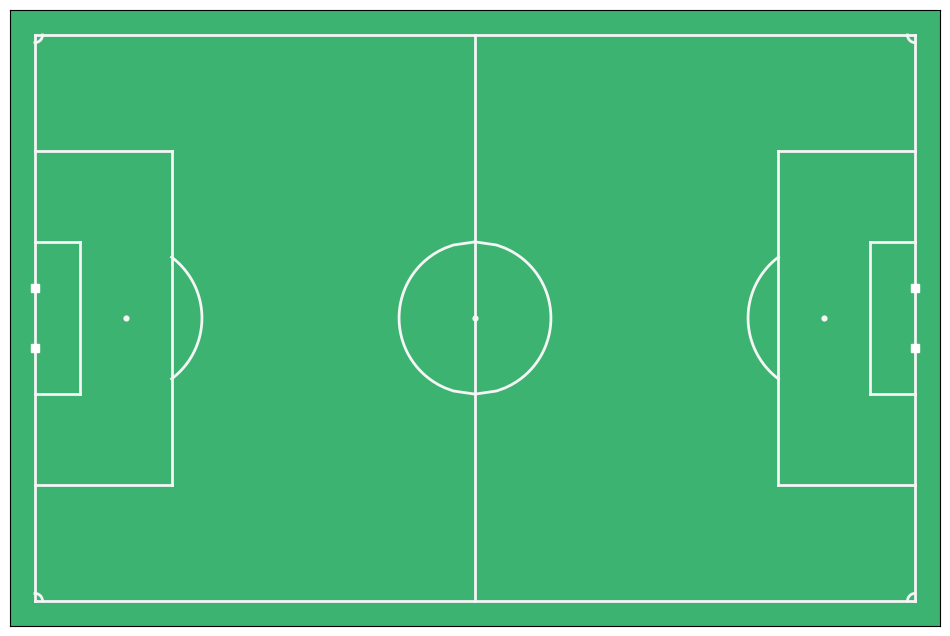

In [14]:
fig,ax = plot_pitch()

In [15]:
#getting all shots
shots = events[events['Type']=='SHOT']
home_shots = home_events[home_events.Type=='SHOT']
away_shots = away_events[away_events.Type=='SHOT']

In [16]:
#getting the shots that led to a goal
home_goals = home_shots[home_shots['Subtype'].str.contains('-GOAL')].copy()
away_goals = away_shots[away_shots['Subtype'].str.contains('-GOAL')].copy()

In [17]:
#getting the final score of the game
home_goals

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,-47.70,-3.40,-54.06,-2.04
1118,Home,SHOT,HEAD-ON TARGET-GOAL,2,73983,2959.32,73995,2959.80,Player9,NaN,47.70,-1.36,54.06,-2.04
1723,Home,SHOT,ON TARGET-GOAL,2,121027,4841.08,121055,4842.20,Player12,NaN,30.74,-5.44,54.06,-2.72


In [18]:
away_goals

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
823,Away,SHOT,ON TARGET-GOAL,1,53049,2121.96,53075,2123.00,Player24,NaN,44.52,2.72,54.06,1.36
1671,Away,SHOT,ON TARGET-GOAL,2,115009,4600.36,115024,4600.96,Player20,NaN,-40.28,-1.36,-55.12,-2.72


### Game Result
Home team won the game with a score of 3-2.

### Plotting the first goal

From the above result we can see that the first goal occured at index 198.

Text(-47.7, -3.400000000000003, '')

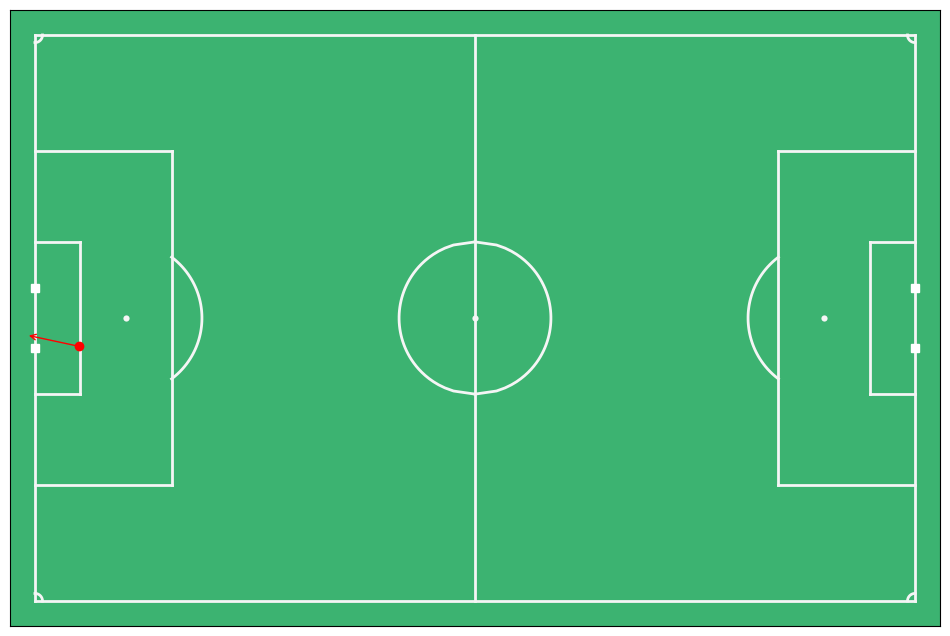

In [19]:
#plotting the first goal
fig,ax = plot_pitch()
ax.plot( events.loc[198]['Start X'], events.loc[198]['Start Y'], 'ro' )
ax.annotate("", xy=events.loc[198][['End X','End Y']], xytext=events.loc[198][['Start X','Start Y']],alpha=0.6, arrowprops=dict(arrowstyle="->",color='r'))


From the above result, we can see that the first goal was scored from almost the edge of the six yard box and the shot was placed to the near post.

### Plotting events in run up to the goal.

In [20]:
#analysing events that happened before the goal
events.loc[187:198]

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
187,Away,BALL LOST,THEFT,1,11534,461.36,11534,461.36,Player22,NaN,-26.50,6.12,NaN,NaN
188,Home,CHALLENGE,TACKLE-WON,1,11641,465.64,11641,465.64,Player7,NaN,-13.78,-0.68,NaN,NaN
189,Home,RECOVERY,THEFT,1,11641,465.64,11641,465.64,Player7,NaN,-13.78,-0.68,NaN,NaN
190,Home,PASS,NaN,1,11647,465.88,11685,467.40,Player7,Player10,-13.78,-0.68,-21.20,-0.00
191,Home,PASS,NaN,1,11685,467.40,11703,468.12,Player10,Player5,-21.20,-0.00,-18.02,4.08
192,Home,PASS,NaN,1,11721,468.84,11744,469.76,Player5,Player9,-20.14,4.08,-30.74,7.48
193,Home,PASS,NaN,1,11810,472.40,11885,475.40,Player9,Player8,-32.86,0.68,-39.22,-25.16
194,Home,PASS,NaN,1,11958,478.32,11976,479.04,Player8,Player9,-41.34,-24.48,-42.40,-14.96
195,Home,PASS,NaN,1,11976,479.04,11994,479.76,Player9,Player8,-42.40,-14.96,-38.16,-20.40
196,Home,PASS,NaN,1,12069,482.76,12146,485.84,Player8,Player1,-28.62,-7.48,-37.10,23.80


We can see that the goal resulted from a move that started at index 189 where the home team recovered the ball. It was followed by a move consisting of 8 passes and then finished off at index 198.

In [21]:
#creating a function that allows to very quickly plot sort of a whole sequence of events one after the other. 
def plot_events( events, figax=None, field_dimen = (106.0,68), indicators = ['Marker','Arrow'], color='r', marker_style = 'o', alpha = 0.5, annotate=False):
    if figax is None: # create new pitch 
        fig,ax = plot_pitch( field_dimen = field_dimen )
    else :
        fig,ax = plot_pitch( field_dimen = field_dimen )
    for i,row in events.iterrows():
        if 'Marker' in indicators:
            ax.plot(  row['Start X'], row['Start Y'],color+marker_style,alpha=alpha )
        if 'Arrow' in indicators:
            ax.annotate("", xy=row[['End X','End Y']], xytext=row[['Start X','Start Y']], alpha=alpha, arrowprops=dict(alpha=alpha,width=0.5,headlength=4.0,headwidth=4.0,color=color),annotation_clip=True)
        if annotate:
            textstring = row['Type'] + ': ' + row['From']
            ax.text( row['Start X'], row['Start Y'], textstring, fontsize=10, color=color) 
    return fig,ax

(<Figure size 1200x800 with 1 Axes>, <Axes: >)

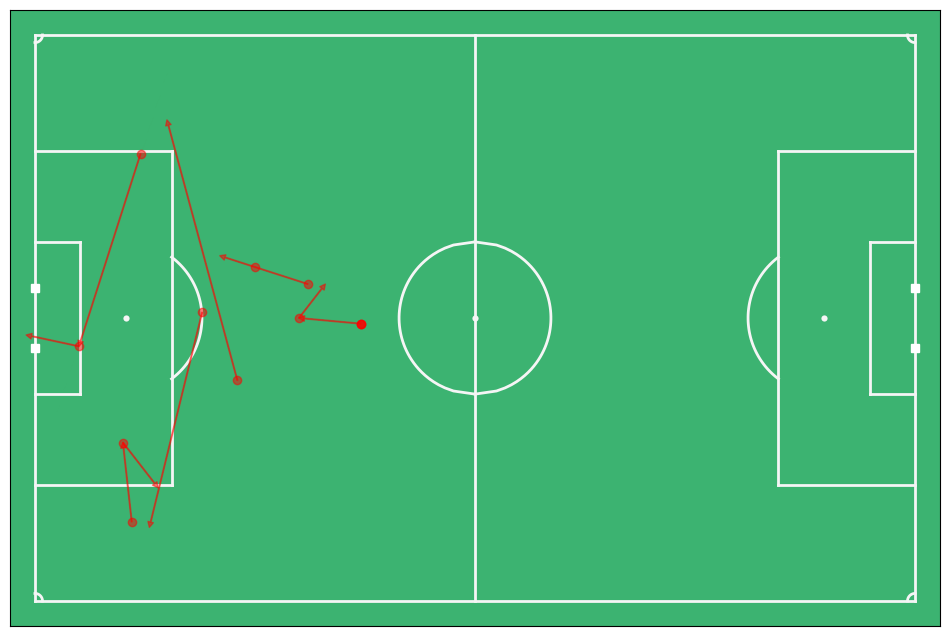

In [22]:
#ploting passing move in run up to goal
plot_events(events.loc[187:198], indicators = ['Marker','Arrow'],annotate = False )

## Exploring the tracking data

In [23]:
#changing coordinate system as did with the events data 
tracking_home = to_metric_coordinates(tracking_home)
tracking_away = to_metric_coordinates(tracking_away)

***
### Plotting some player trajectories (players 11,1,2,3,4) during the first minute of the match.

We have data for every 4ms. So for 1 second we have 25 data points. Therefore for 1 minute we will have 25*60 = 1500 data points.

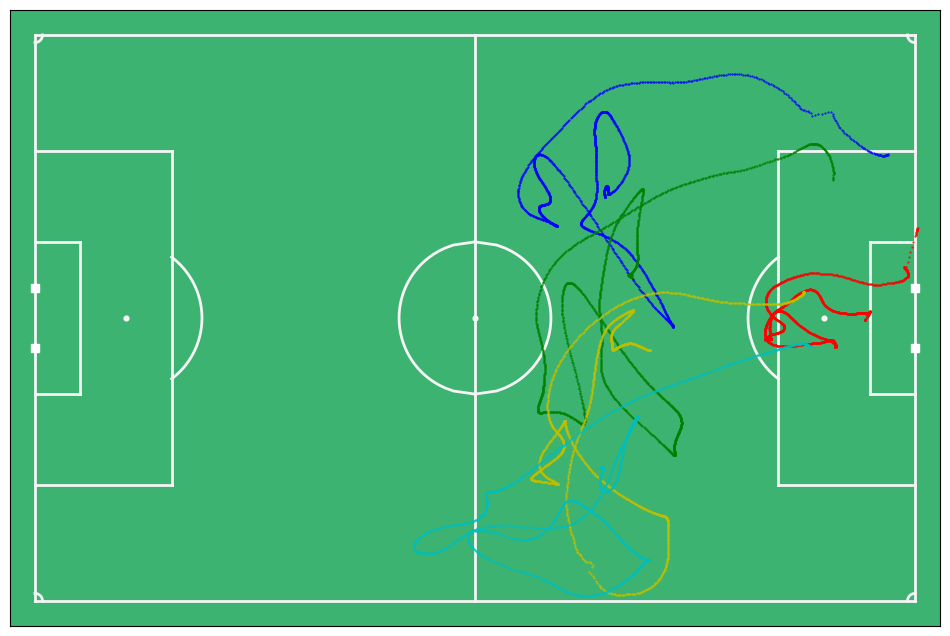

In [24]:
#plotting some player trajectories (players 11,1,2,3,4 of home team) during the first minute of the match
fig,ax = plot_pitch()
ax.plot( tracking_home['Home_11_x'].iloc[:1500], tracking_home['Home_11_y'].iloc[:1500], 'r.', markersize=1)
ax.plot( tracking_home['Home_1_x'].iloc[:1500], tracking_home['Home_1_y'].iloc[:1500], 'b.', markersize=1)
ax.plot( tracking_home['Home_2_x'].iloc[:1500], tracking_home['Home_2_y'].iloc[:1500], 'g.', markersize=1)
ax.plot( tracking_home['Home_3_x'].iloc[:1500], tracking_home['Home_3_y'].iloc[:1500], 'y.', markersize=1)
ax.plot( tracking_home['Home_4_x'].iloc[:1500], tracking_home['Home_4_y'].iloc[:1500], 'c.', markersize=1)

Looking at the above plot, we can fairly conclude that the player 11 is the goalkeeper and the rest of the players are likely to be the defenders.

### Visualising the kick-off frame.



In [25]:
#assigning colour red to home team and blue to away team.
team_colors=('r','b')
for team,color in zip( [tracking_home,tracking_away], team_colors) :
    print(team.keys())

Index(['Period', 'Time [s]', 'Home_11_x', 'Home_11_y', 'Home_1_x', 'Home_1_y',
       'Home_2_x', 'Home_2_y', 'Home_3_x', 'Home_3_y', 'Home_4_x', 'Home_4_y',
       'Home_5_x', 'Home_5_y', 'Home_6_x', 'Home_6_y', 'Home_7_x', 'Home_7_y',
       'Home_8_x', 'Home_8_y', 'Home_9_x', 'Home_9_y', 'Home_10_x',
       'Home_10_y', 'Home_12_x', 'Home_12_y', 'Home_13_x', 'Home_13_y',
       'Home_14_x', 'Home_14_y', 'ball_x', 'ball_y'],
      dtype='object')
Index(['Period', 'Time [s]', 'Away_25_x', 'Away_25_y', 'Away_15_x',
       'Away_15_y', 'Away_16_x', 'Away_16_y', 'Away_17_x', 'Away_17_y',
       'Away_18_x', 'Away_18_y', 'Away_19_x', 'Away_19_y', 'Away_20_x',
       'Away_20_y', 'Away_21_x', 'Away_21_y', 'Away_22_x', 'Away_22_y',
       'Away_23_x', 'Away_23_y', 'Away_24_x', 'Away_24_y', 'Away_26_x',
       'Away_26_y', 'ball_x', 'ball_y'],
      dtype='object')


In [26]:
#identifying the kick-off frame
events.loc[0]['Start Frame']

51

So the kick off happens at frame 51 of the tracking data.

In [27]:
#plotting the kick-off frame
def plot_frame( hometeam, awayteam, figax=None, team_colors=('r','b'), field_dimen = (106.0,68.0), include_player_velocities=False, PlayerMarkerSize=10, PlayerAlpha=0.7, annotate=False ):

    if figax is None: # create new pitch 
        fig,ax = plot_pitch( field_dimen = field_dimen )
    else: # overlay on a previously generated pitch
        fig,ax = figax # unpack tuple
    # plot home & away teams in order
    for team,color in zip( [hometeam,awayteam], team_colors) :
        x_columns = [c for c in team.keys() if c[-2:].lower()=='_x' and c!='ball_x'] # column header for player x positions
        y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' and c!='ball_y'] # column header for player y positions
        ax.plot( team[x_columns], team[y_columns], color+'o', markersize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
        if include_player_velocities:
            vx_columns = ['{}_vx'.format(c[:-2]) for c in x_columns] # column header for player x positions
            vy_columns = ['{}_vy'.format(c[:-2]) for c in y_columns] # column header for player y positions
            ax.quiver( team[x_columns], team[y_columns], team[vx_columns], team[vy_columns], color=color, scale_units='inches', scale=10.,width=0.0015,headlength=5,headwidth=3,alpha=PlayerAlpha)
        if annotate:
            [ ax.text( team[x]+0.5, team[y]+0.5, x.split('_')[1], fontsize=10, color=color  ) for x,y in zip(x_columns,y_columns) if not ( np.isnan(team[x]) or np.isnan(team[y]) ) ] 
    # plot ball
    ax.plot( hometeam['ball_x'], hometeam['ball_y'], 'ko', markersize=6, alpha=1.0, linewidth=0)
    return fig,ax

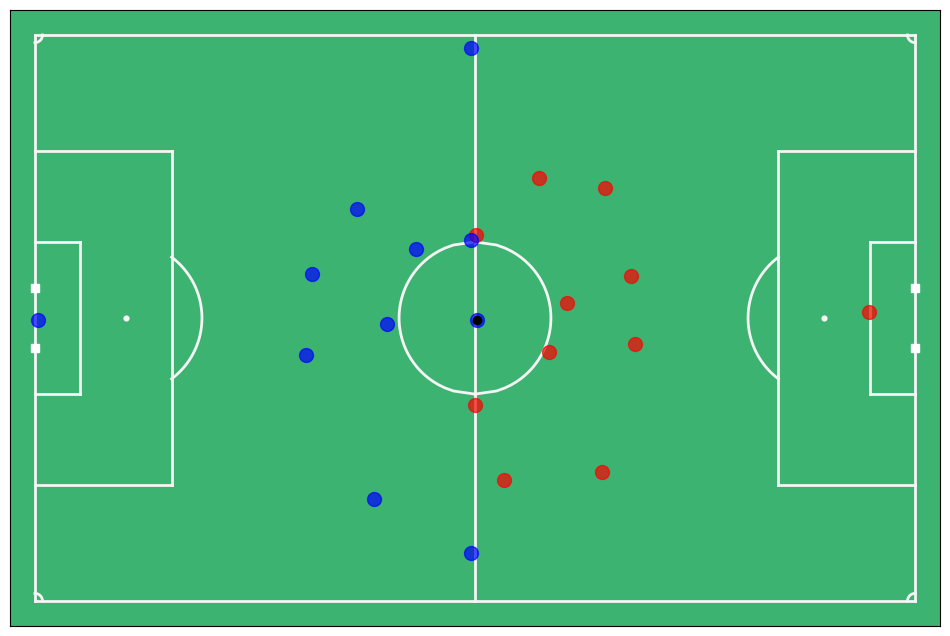

In [28]:
#player positions at kick-off
kickoff = events.loc[0]['Start Frame']
fig,ax = plot_frame( tracking_home.loc[kickoff], tracking_away.loc[kickoff] )

### Analysing the first goal

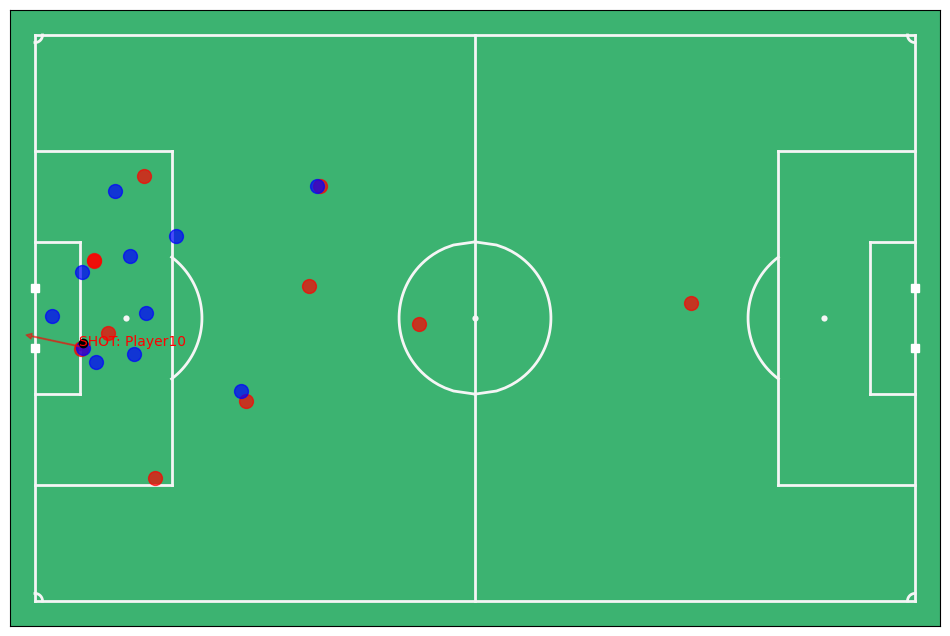

In [29]:
#player positions at first goal
fig,ax = plot_events( events.loc[198:198], indicators = ['Marker','Arrow'], annotate=True )
goal_frame = events.loc[198]['Start Frame']
fig,ax = plot_frame( tracking_home.loc[goal_frame], tracking_away.loc[goal_frame], figax = (fig,ax), annotate=False )



In this plot, we have the positions of all players which gives us more clarity as compared to the previous plot.

### Making a movie clip of the first goal

In [30]:
#changing playing direction in second half so that the playing direction remains same throughout
def to_single_playing_direction(home,away,events):
    '''
    Flip coordinates in second half so that each team always shoots in the same direction through the match.
    '''
    for team in [home,away,events]:
        second_half_idx = team.Period.eq(2).idxmax()
        columns = [c for c in team.columns if c[-1].lower() in ['x','y']]
        team.loc[second_half_idx:,columns] *= -1
    return home,away,events

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home,tracking_away,events = to_single_playing_direction(tracking_home,tracking_away,events)

In [31]:
#setting the directory to save the clip
PLOTDIR = "/Users/gkrish/Documents/Football Performance Analysis/\
sample-data-master/data/"

In [32]:
#function to create the match clip
def save_match_clip(hometeam,awayteam, fpath, fname='clip_test', figax=None, frames_per_second=25, team_colors=('r','b'), field_dimen = (106.0,68.0), include_player_velocities=False, PlayerMarkerSize=10, PlayerAlpha=0.7):

    # check that indices match first
    assert np.all( hometeam.index==awayteam.index ), "Home and away team Dataframe indices must be the same"
    # in which case use home team index
    index = hometeam.index
    # Set figure and movie settings
    FFMpegWriter = animation.writers['ffmpeg']
    metadata = dict(title='Tracking Data', artist='Matplotlib', comment='Metrica tracking data clip')
    writer = FFMpegWriter(fps=frames_per_second, metadata=metadata)
    fname = fpath + '/' +  fname + '.mp4' # path and filename
    # create football pitch
    if figax is None:
        fig,ax = plot_pitch(field_dimen=field_dimen)
    else:
        fig,ax = figax
    fig.set_tight_layout(True)
    # Generate movie
    print("Generating movie...",end='')
    with writer.saving(fig, fname, 100):
        for i in index:
            figobjs = [] # this is used to collect up all the axis objects so that they can be deleted after each iteration
            for team,color in zip( [hometeam.loc[i],awayteam.loc[i]], team_colors) :
                x_columns = [c for c in team.keys() if c[-2:].lower()=='_x' and c!='ball_x'] # column header for player x positions
                y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' and c!='ball_y'] # column header for player y positions
                objs, = ax.plot( team[x_columns], team[y_columns], color+'o', markersize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
                figobjs.append(objs)
                if include_player_velocities:
                    vx_columns = ['{}_vx'.format(c[:-2]) for c in x_columns] # column header for player x positions
                    vy_columns = ['{}_vy'.format(c[:-2]) for c in y_columns] # column header for player y positions
                    objs = ax.quiver( team[x_columns], team[y_columns], team[vx_columns], team[vy_columns], color=color, scale_units='inches', scale=10.,width=0.0015,headlength=5,headwidth=3,alpha=PlayerAlpha)
                    figobjs.append(objs)
            # plot ball
            objs, = ax.plot( team['ball_x'], team['ball_y'], 'ko', markersize=6, alpha=1.0, linewidth=0)
            figobjs.append(objs)
            # include match time at the top
            frame_minute =  int( team['Time [s]']/60. )
            frame_second =  ( team['Time [s]']/60. - frame_minute ) * 60.
            timestring = "%d:%1.2f" % ( frame_minute, frame_second  )
            objs = ax.text(-2.5,field_dimen[1]/2.+1., timestring, fontsize=14 )
            figobjs.append(objs)
            writer.grab_frame()
            # Delete all axis objects (other than pitch lines) in preperation for next frame
            for figobj in figobjs:
                figobj.remove()
    print("done")
    plt.clf()
    plt.close(fig) 

In [33]:
save_match_clip(tracking_home.iloc[11647:12300],tracking_away.iloc[11647:12300],PLOTDIR,fname='home_goal_1',include_player_velocities=False)

Generating movie...done


### Calculating player velocities

In [34]:
def calc_player_velocities(team, smoothing=True, filter_='Savitzky-Golay', window=7, polyorder=1, maxspeed = 12):
   
    #removing any velocity data already in the dataframe
    team = remove_player_velocities(team)
    
    #getting the player ids
    player_ids = np.unique( [ c[:-2] for c in team.columns if c[:4] in ['Home','Away'] ] )

    #calculating the timestep from one frame to the next. Should always be 0.04 within the same half
    dt = team['Time [s]'].diff()
    
    #index of first frame in second half
    second_half_idx = team.Period.eq(2).idxmax()
    
    #estimating velocities for players in team
    for player in player_ids: # cycle through players individually
        # difference player positions in timestep dt to get unsmoothed estimate of velicity
        vx = team[player+"_x"].diff() / dt
        vy = team[player+"_y"].diff() / dt

        if maxspeed>0:
            # remove unsmoothed data points that exceed the maximum speed (these are most likely position errors)
            raw_speed = np.sqrt( vx**2 + vy**2 )
            vx[ raw_speed>maxspeed ] = np.nan
            vy[ raw_speed>maxspeed ] = np.nan
            
        if smoothing:
            if filter_=='Savitzky-Golay':
                # calculate first half velocity
                vx.loc[:second_half_idx] = signal.savgol_filter(vx.loc[:second_half_idx],window_length=window,polyorder=polyorder)
                vy.loc[:second_half_idx] = signal.savgol_filter(vy.loc[:second_half_idx],window_length=window,polyorder=polyorder)        
                # calculate second half velocity
                vx.loc[second_half_idx:] = signal.savgol_filter(vx.loc[second_half_idx:],window_length=window,polyorder=polyorder)
                vy.loc[second_half_idx:] = signal.savgol_filter(vy.loc[second_half_idx:],window_length=window,polyorder=polyorder)
            elif filter_=='moving average':
                ma_window = np.ones( window ) / window 
                # calculate first half velocity
                vx.loc[:second_half_idx] = np.convolve( vx.loc[:second_half_idx] , ma_window, mode='same' ) 
                vy.loc[:second_half_idx] = np.convolve( vy.loc[:second_half_idx] , ma_window, mode='same' )      
                # calculate second half velocity
                vx.loc[second_half_idx:] = np.convolve( vx.loc[second_half_idx:] , ma_window, mode='same' ) 
                vy.loc[second_half_idx:] = np.convolve( vy.loc[second_half_idx:] , ma_window, mode='same' ) 
                
        
        #putting player speed in x,y direction, and total speed back in the data frame
        team[player + "_vx"] = vx
        team[player + "_vy"] = vy
        team[player + "_speed"] = np.sqrt( vx**2 + vy**2 )

    return team

In [35]:
def remove_player_velocities(team):
    #removing player velocoties and acceleration measures that are already in the 'team' dataframe
    columns = [c for c in team.columns if c.split('_')[-1] in ['vx','vy','ax','ay','speed','acceleration']] # Get the player ids
    team = team.drop(columns=columns)
    return team

In [36]:
#adding velocity values to the tracking dataframe
tracking_home = calc_player_velocities(tracking_home,smoothing=True)
tracking_away = calc_player_velocities(tracking_away,smoothing=True)

In [37]:
#validating tracking dataframe
tracking_home.columns

Index(['Period', 'Time [s]', 'Home_11_x', 'Home_11_y', 'Home_1_x', 'Home_1_y',
       'Home_2_x', 'Home_2_y', 'Home_3_x', 'Home_3_y', 'Home_4_x', 'Home_4_y',
       'Home_5_x', 'Home_5_y', 'Home_6_x', 'Home_6_y', 'Home_7_x', 'Home_7_y',
       'Home_8_x', 'Home_8_y', 'Home_9_x', 'Home_9_y', 'Home_10_x',
       'Home_10_y', 'Home_12_x', 'Home_12_y', 'Home_13_x', 'Home_13_y',
       'Home_14_x', 'Home_14_y', 'ball_x', 'ball_y', 'Home_1_vx', 'Home_1_vy',
       'Home_1_speed', 'Home_10_vx', 'Home_10_vy', 'Home_10_speed',
       'Home_11_vx', 'Home_11_vy', 'Home_11_speed', 'Home_12_vx', 'Home_12_vy',
       'Home_12_speed', 'Home_13_vx', 'Home_13_vy', 'Home_13_speed',
       'Home_14_vx', 'Home_14_vy', 'Home_14_speed', 'Home_2_vx', 'Home_2_vy',
       'Home_2_speed', 'Home_3_vx', 'Home_3_vy', 'Home_3_speed', 'Home_4_vx',
       'Home_4_vy', 'Home_4_speed', 'Home_5_vx', 'Home_5_vy', 'Home_5_speed',
       'Home_6_vx', 'Home_6_vy', 'Home_6_speed', 'Home_7_vx', 'Home_7_vy',
       'Home_7_spe

### Physical summary report (Home team)

In [38]:
#creating a physical summary dataframe for home players
home_players = np.unique( [ c.split('_')[1] for c in tracking_home.columns if c[:4] == 'Home' ] )
home_summary = pd.DataFrame(index=home_players)

In [39]:
#calculating minutes played for each player
minutes = []
for player in home_players:
    # search for first and last frames that we have a position observation for each player (when a player is not on the pitch positions are NaN)
    column = 'Home_' + player + '_x' # use player x-position coordinate
    player_minutes = ( tracking_home[column].last_valid_index() - tracking_home[column].first_valid_index() + 1 ) / 25 / 60. # convert to minutes
    minutes.append( player_minutes )
home_summary['Minutes Played'] = minutes
home_summary = home_summary.sort_values(['Minutes Played'], ascending=False)

In [40]:
#calculating total distance covered for each player
distance = []
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    player_distance = tracking_home[column].sum()/25./1000 # this is the sum of the distance travelled from one observation to the next (1/25 = 40ms) in km.
    distance.append( player_distance )
home_summary['Distance [km]'] = distance

In [41]:
#validating the results
home_summary

,Minutes Played,Distance [km]
1,94.104000,10.369966
11,94.104000,5.203820
2,94.104000,9.845300
3,94.104000,9.546312
5,94.104000,11.909182
6,94.104000,11.535969
7,94.104000,11.068739
9,94.104000,9.765283
10,83.825333,8.959440
8,70.740667,9.012902


Text(0, 0.5, 'Distance covered [km]')

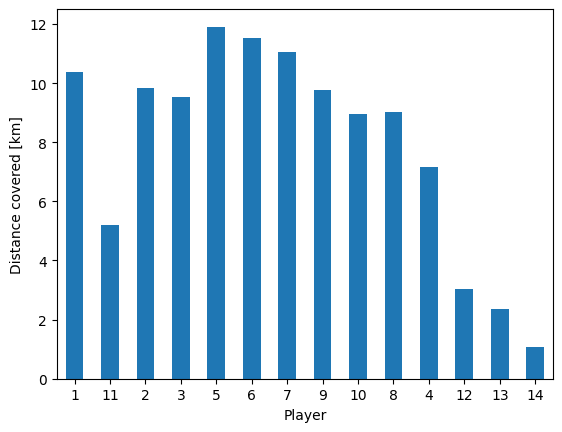

In [42]:
#bar chart of distance covered for each player
plt.subplots()
ax = home_summary['Distance [km]'].plot.bar(rot=0)
ax.set_xlabel('Player')
ax.set_ylabel('Distance covered [km]')

We can see that on average a player has covered a distance between 10-12 kms if played for 90 minutes.<br>
Player 11 who is the GK has covered around 5kms.

In [43]:
#calculating distance covered while: walking, joggings, running, sprinting
walking = []
jogging = []
running = []
sprinting = []
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    # walking (less than 2 m/s)
    player_distance = tracking_home.loc[tracking_home[column] < 2, column].sum()/25./1000
    walking.append( player_distance )
    # jogging (between 2 and 4 m/s)
    player_distance = tracking_home.loc[ (tracking_home[column] >= 2) & (tracking_home[column] < 4), column].sum()/25./1000
    jogging.append( player_distance )
    # running (between 4 and 7 m/s)
    player_distance = tracking_home.loc[ (tracking_home[column] >= 4) & (tracking_home[column] < 7), column].sum()/25./1000
    running.append( player_distance )
    # sprinting (greater than 7 m/s)
    player_distance = tracking_home.loc[ tracking_home[column] >= 7, column].sum()/25./1000
    sprinting.append( player_distance )
    
home_summary['Walking [km]'] = walking
home_summary['Jogging [km]'] = jogging
home_summary['Running [km]'] = running
home_summary['Sprinting [km]'] = sprinting

In [44]:
#validating the results
home_summary

,Minutes Played,Distance [km],Walking [km],Jogging [km],Running [km],Sprinting [km]
1,94.104000,10.369966,3.701953,4.436083,2.149219,0.082712
11,94.104000,5.203820,4.394682,0.777765,0.029655,0.001718
2,94.104000,9.845300,4.085937,4.066061,1.612491,0.080811
3,94.104000,9.546312,4.178461,3.832849,1.382836,0.152166
5,94.104000,11.909182,3.583949,4.652462,3.519102,0.153669
6,94.104000,11.535969,3.385553,5.145440,2.829522,0.175454
7,94.104000,11.068739,3.606788,4.956883,2.324597,0.180470
9,94.104000,9.765283,4.428139,3.322470,1.863521,0.151153
10,83.825333,8.959440,3.858442,3.430553,1.404684,0.265760
8,70.740667,9.012902,2.604774,4.133859,2.183218,0.091051


Text(0, 0.5, 'Distance covered [m]')

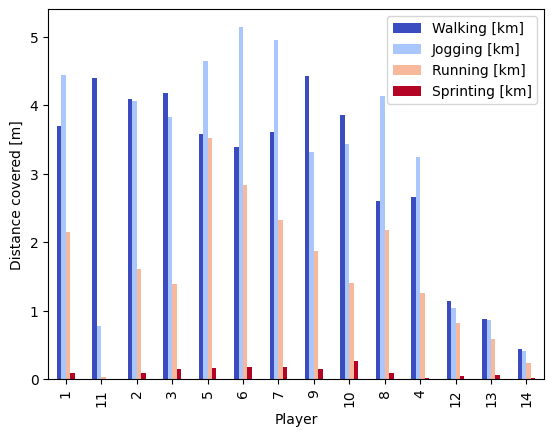

In [45]:
#clustered bar chart of distance covered for each player at each speed
ax = home_summary[['Walking [km]','Jogging [km]','Running [km]','Sprinting [km]']].plot.bar(colormap='coolwarm')
ax.set_xlabel('Player')
ax.set_ylabel('Distance covered [m]')

In [46]:
#calculating sustained sprints: Defined as maintaining a speed > 7 m/s for at least 1 second
nsprints = []
sprint_threshold = 7 # minimum speed to be defined as a sprint (m/s)
sprint_window = 1*25 # minimum duration sprint should be sustained (in this case, 1 second = 25 consecutive frames)
for player in home_summary.index:
    column = 'Home_' + player + '_speed'
    player_sprints = np.diff( 1*( np.convolve( 1*(tracking_home[column]>=sprint_threshold), np.ones(sprint_window), mode='same' ) >= sprint_window ) )
    nsprints.append( np.sum( player_sprints == 1 ) )
home_summary['# sprints'] = nsprints

In [47]:
home_summary

,Minutes Played,Distance [km],Walking [km],Jogging [km],Running [km],Sprinting [km],# sprints
1,94.104000,10.369966,3.701953,4.436083,2.149219,0.082712,5
11,94.104000,5.203820,4.394682,0.777765,0.029655,0.001718,0
2,94.104000,9.845300,4.085937,4.066061,1.612491,0.080811,3
3,94.104000,9.546312,4.178461,3.832849,1.382836,0.152166,8
5,94.104000,11.909182,3.583949,4.652462,3.519102,0.153669,8
6,94.104000,11.535969,3.385553,5.145440,2.829522,0.175454,7
7,94.104000,11.068739,3.606788,4.956883,2.324597,0.180470,9
9,94.104000,9.765283,4.428139,3.322470,1.863521,0.151153,7
10,83.825333,8.959440,3.858442,3.430553,1.404684,0.265760,13
8,70.740667,9.012902,2.604774,4.133859,2.183218,0.091051,6
